# Define Poisson equation

## Import modules

In [1]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
from discretize import TensorMesh
from discretize.utils import mkvc

from simpeg_ecosys.mathematical import PoissonCellCentered, VolumeSource

# Suppress all warnings
warnings.filterwarnings('ignore')

## Set the mesh

In [2]:
delta = 1
hx = np.ones(5) * delta
origin = [0]
mesh = TensorMesh([hx], origin=origin)
bc_types = [["dirichlet", "dirichlet"]]
bc_values = [[0, 0]]
print(mesh)


  TensorMesh: 5 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      5          0.00          5.00      1.00      1.00    1.00




## Set the model parameters (diffusion coefficient)

In [3]:
# uniform medium
model_parameters = mkvc(1 * np.ones(mesh.n_cells))

## Set the source term

In [4]:
source1 = VolumeSource([[mesh.cell_centers_x[(mesh.n_cells//2)]]], values=[1])
source_list = [source1]

print(source_list)

[
       locations    |        values
--------------------+------------------
    [    2.5000]    |        1.0000    
]


## Construct a PoissonCellCentered instance

In [5]:
poisson = PoissonCellCentered(
    mesh, bc_types, bc_values,
    source_list=source_list,
    model_parameters=model_parameters
)

# Solve Poisson's equation using conventional numerical methods

## Import modules

In [6]:
import scipy.sparse as sp
import scipy.sparse.linalg

## Solve poisson's equation by `scipy.sparse.linalg.splu` and `scipy.sparse.linalg.spsolve`

In [7]:
A = poisson.getA().toarray()
b = poisson.getRHS()
print(f"A:\n{A}")
print(f"b:\n{b}")

lu = sp.linalg.splu(A)
x_lu = lu.solve(b)
x = sp.linalg.spsolve(A, b)
if not np.all(np.isclose(x_lu, x)):
    raise ArithmeticError

A:
[[ 3. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  3.]]
b:
[0. 0. 1. 0. 0.]


## Show result

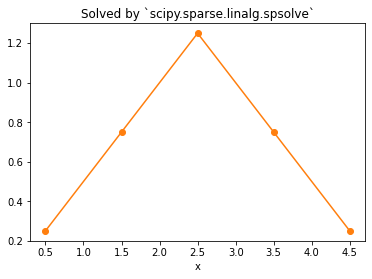

x:
[0.25 0.75 1.25 0.75 0.25]


In [8]:
mesh.plot_image(x)
plt.title("Solved by `scipy.sparse.linalg.spsolve`")
plt.show()
print(f"x:\n{x}")

# Solve Poisson's equation using Quantum Annealing (Direct QPU)

## Import modules

In [9]:
from neal import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler

from dwaveutils import bl_lstsq

## Construct a DirectSolver instance

In [10]:
solver = bl_lstsq.DirectSolver(A, b)

## Set sampler and parameters for `DirectSolver.solve` method

In [12]:
sampler = EmbeddingComposite(
    DWaveSampler(solver={'qpu': True}, postprocess="sampling")
)  # use postprocess
# sampler = SimulatedAnnealingSampler()
sampling_params = {
    "num_reads": 1000,
    "chain_strength": 100,
    "answer_mode": "histogram"
}
qubo_params = {
    "num_bits": 4,
    "fixed_point": 1,
    "sign": "pn",
    "eq_scaling_val": 1/8,
}

## Solve

In [13]:
result = solver.solve(sampler=sampler, sampling_params=sampling_params, qubo_params=qubo_params)
x_directsolver = result["x"]

## Show result

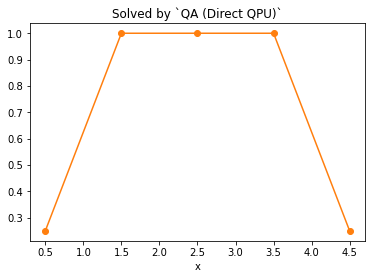

x:
[0.25 1.   1.   1.   0.25]


In [14]:
mesh.plot_image(x_directsolver)
plt.title("Solved by `QA (Direct QPU)`")
plt.show()
print(f"x:\n{x_directsolver}")

# Solve Poisson's equation using Quantum Annealing (Direct QPU) through an iterative procedure

## Construct a IterativeSolver instance

In [15]:
solver = bl_lstsq.IterativeSolver(A, b)

## Set sampler and parameters for `IterativeSolver.solve` method

In [16]:
sampler = EmbeddingComposite(
    DWaveSampler(solver={'qpu': True}, postprocess="sampling")
)  # use postprocess
# sampler = SimulatedAnnealingSampler()
sampling_params = {
    "num_reads": 1000,
    "chain_strength": 100,
    "answer_mode": "histogram"
}
qubo_params = {
    "num_bits": 2,
    "fixed_point": 1,
    "sign": "p",
    "eq_scaling_val": 1/8,
}
iter_params = {
    "scale_factor": 2,
    "num_iter": 20,
    "l2_res_tol": 1e-3,
    "verbose": True
}
rng = np.random.default_rng()
initial_x = (1 - (-1)) * rng.random(b.size) + (-1)

## Solve

In [17]:
result = solver.solve(
    initial_x,
    sampler=sampler,
    sampling_params=sampling_params,
    qubo_params=qubo_params,
    iter_params=iter_params
)
x_iterativesolver = result["x"]

Iter: 1
    x: [ 0.1725  0.2897  0.0358 -0.9747 -0.5174]
    l2_res: 1.6544e+00
Iter: 2
    x: [ 0.1725  0.2897  0.0358 -0.9747 -0.5174]
    l2_res: 1.6544e+00
Iter: 3
    x: [ 0.1725  0.2897  0.0358 -0.3081  0.1492]
    l2_res: 1.4936e+00
Iter: 4
    x: [0.1725 0.2897 0.4803 0.1364 0.1492]
    l2_res: 7.0584e-01
Iter: 5
    x: [0.1725 0.2897 0.7766 0.4327 0.1492]
    l2_res: 4.7022e-01
Iter: 6
    x: [0.1725 0.4872 0.9741 0.6302 0.1492]
    l2_res: 3.3358e-01
Iter: 7
    x: [0.1725 0.6847 1.1716 0.6302 0.1492]
    l2_res: 2.5762e-01
Iter: 8
    x: [0.1725 0.6847 1.1716 0.7619 0.2809]
    l2_res: 2.2561e-01
Iter: 9
    x: [0.2603 0.7725 1.2594 0.7619 0.2809]
    l2_res: 8.8165e-02
Iter: 10
    x: [0.2603 0.7725 1.2594 0.7619 0.2809]
    l2_res: 8.8165e-02
Iter: 11
    x: [0.2603 0.714  1.2009 0.7034 0.2224]
    l2_res: 8.6019e-02
Iter: 12
    x: [0.2603 0.714  1.2009 0.7034 0.2224]
    l2_res: 8.6019e-02
Iter: 13
    x: [0.2213 0.714  1.2009 0.7034 0.2224]
    l2_res: 6.6151e-02
Iter: 

## Show result

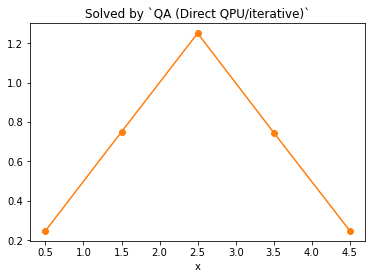

x:
[0.24729304 0.75030235 1.2511147  0.74671503 0.24841204]


In [18]:
mesh.plot_image(x_iterativesolver)
plt.title("Solved by `QA (Direct QPU/iterative)`")
plt.show()
print(f"x:\n{x_iterativesolver}")